In [32]:
import sys
sys.path.append('../')

import numpy as np
from scipy import ndimage

from skimage.filters import sobel_h
from skimage.filters import sobel_v
from scipy import stats


import os
import matplotlib
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from mpl_toolkits.mplot3d.proj3d import proj_transform
from matplotlib.patches import FancyArrowPatch
from mpl_toolkits.mplot3d import proj3d


import scienceplots
from tensorflow.python.client import device_lib

#plt.rcParams['figure.figsize'] = [10,10]

import tensorflow as tf
from tensorflow.keras.preprocessing import image
from tensorflow.keras.applications.vgg16 import decode_predictions
from tensorflow.keras.applications import VGG16

from tensorflow.nn import depthwise_conv2d
from tensorflow.math import multiply, reduce_sum, reduce_mean,reduce_euclidean_norm, sin, cos, abs
from tensorflow import stack, concat, expand_dims

import tensorflow_probability as tfp

from utils.utils import *
import cv2

from scipy import ndimage, fft

plt.style.use(['science', 'ieee'])
plt.rcParams.update({'figure.dpi': '100'})

#### Experiment #1 : HandCrafted AntiSymmetric Bipolar Convolution


In [33]:
k = 20 # Top 10% highest l2-magnitude filters

In [34]:
F = 0
k = 2
filters = np.zeros((k,k,1,1))

t = np.zeros((k,k))
t[1,0] = np.sqrt(0.25)
t[0, 0] = np.sqrt(1-0.25)
filters = np.reshape(fft.idctn(t, norm=None), (k,k,1,1))
#filters /= np.sum(filters**2)
#filters[:,:,0,0] =  (1/9)*np.array([[1,1,1], [1,1,1], [1,1,1]]) + (1/6)*np.array([[1,1,1], [0,0,0], [-1,-1,-1]]) 

'''
theta = getSobelTF(filters)
print(filters.shape)
s, a = getSymAntiSymTF(filters)

a_mag = reduce_euclidean_norm(a, axis=[0,1])
s_mag = reduce_euclidean_norm(s, axis=[0,1])
mag = reduce_euclidean_norm(filters, axis=[0,1])


x =(a_mag[:,F]*np.cos((theta[:,F]))).numpy()
y =( a_mag[:,F]*np.sin((theta[:,F]))).numpy()
z =(s_mag[:,F]*np.sign(np.mean(s, axis=(0,1)))[:,F]).numpy()
plt.rcParams.update({'figure.dpi': '100'})

'''


"\ntheta = getSobelTF(filters)\nprint(filters.shape)\ns, a = getSymAntiSymTF(filters)\n\na_mag = reduce_euclidean_norm(a, axis=[0,1])\ns_mag = reduce_euclidean_norm(s, axis=[0,1])\nmag = reduce_euclidean_norm(filters, axis=[0,1])\n\n\nx =(a_mag[:,F]*np.cos((theta[:,F]))).numpy()\ny =( a_mag[:,F]*np.sin((theta[:,F]))).numpy()\nz =(s_mag[:,F]*np.sign(np.mean(s, axis=(0,1)))[:,F]).numpy()\nplt.rcParams.update({'figure.dpi': '100'})\n\n"

In [35]:
3//2

1

In [36]:
#var = 2/(128*9)

img = np.zeros((115,115)) # cv2.imread('input4.png', 0)/255. 
mid = img.shape[0]//2
img[mid, mid] = 1.
#img = (img-np.mean(img))/np.std(img)
#img = tf.repeat(tf.expand_dims([img], axis=-1) , repeats = 512, axis=-1)  #get_double_slit(shape) , axis=0)
print(img.shape)

(115, 115)


In [37]:
np.var(img), 1/(128*9)


(np.float64(7.560864919722271e-05), 0.0008680555555555555)

In [38]:
np.linspace(-round(0.1)-1, round(0.1)+1, int(0.5*(0.1)+3))

array([-1.,  0.,  1.])

(2, 2, 1, 1)
0
(1, 115, 115, 1)
tf.Tensor(
[[0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [1.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]], shape=(115, 1), dtype=float32)
VALS 1.0
tf.Tensor(0.0, shape=(), dtype=float32) 0.0
(1, 115, 115, 1)
1
(1, 115, 115, 1)
tf.Tensor(
[[0.        ]
 [0.        ]
 [0.        ]
 [0.        ]
 [0.        ]
 [0.        ]
 [0.        ]
 [0.        ]
 [0.        ]
 [0.    

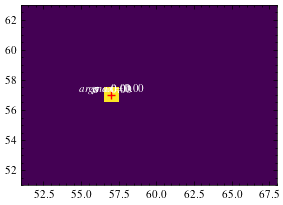

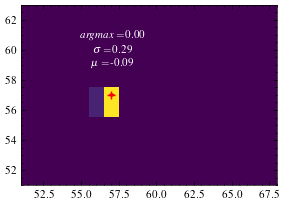

In [39]:
import matplotlib.patches as mpatches

w =tf.cast(filters, dtype=tf.float32)# tf.expand_dims(filters, -1), dtype=tf.float32)
w = tf.transpose(w, perm=(1,0,2,3))
print(w.shape)

x = img


directory = f"figures/prop_unipolar_0.25"
if not os.path.exists(directory):
	os.makedirs(directory)
x = tf.cast(tf.repeat(tf.expand_dims([img], axis=-1) , repeats = filters.shape[-2], axis=-1), dtype=tf.float32) 
for i in range(2):
	print(i)
	#if i in [0,1, 20, 40, 60, 80, 100]:
	fig, ax = plt.subplots()
	print(x.shape)
	x = x/np.std(x)
	vals = x[0, x.shape[1]//2, :, :]
	vals = vals/np.sum(vals)
	print(vals)

	print("VALS", np.sum(vals))
	pos = np.expand_dims(np.linspace(-(x.shape[1]//2), x.shape[1]//2, x.shape[1]),-1)
	mean = tf.reduce_sum(pos*vals)
	var = tf.reduce_sum(((pos-mean)**2) * vals)
	std = np.sqrt(var)
	print(mean, np.sqrt(var))
	
	#x = tf.repeat(x , repeats = filters.shape[-2], axis=-1)
	print(x.shape)

	im = ax.imshow(np.sum(x[0,:,:,:], axis=-1))
	ax.plot(mid, mid, marker = '+', color='red')

	#ax.plot(112+mean, 112, marker = ".", color='black')
	arr =  mpatches.FancyArrowPatch((mid+mean, mid), (mid+mean+std, mid),
							mutation_scale=4, shrinkA=0, shrinkB=0,zorder=10, color="red")
	ax.add_patch(arr)
	
	ax.annotate(r'$\sigma=$'+f"{std:.2f}", (.5, 15), xycoords=arr, ha='center', va='bottom',color='white')
	ax.annotate(r'$\mu=$'+f"{mean:.2f}", (.5, 10), xycoords=arr, ha='center', va='bottom',color='white')
	ax.annotate(r'$argmax=$'+f"{np.argmax(vals)-mid:.2f}", (.5, 20), xycoords=arr, ha='center', va='bottom',color='white')


	#ax.annotate(r'$\sigma=$'+f"{std:.2f}", (.5, 6), xycoords=arr, ha='center', va='bottom',color='white')
	#ax.arrow(, 112, dx=, dy= 0, color='black')

	ax.set(xlim=( (mid-(5)-1), (mid+(10)+1)), ylim=((mid-(5)-1), (mid+(5)+1)))
	#ax.set_xticks(np.linspace(-round(std)-1, round(std)+1, int(0.5*(std)+3)))
	#fig.colorbar(im, orientation='vertical')
	fig.savefig(directory + f'/{i}.pdf', dpi=150,  transparent=True, bbox_inches='tight')

	x = tf.nn.relu( tf.nn.conv2d(x, w , strides=(1,1), 
							padding='SAME') )

(0.0, 224.0)

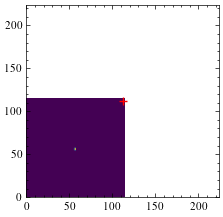

In [40]:
x = tf.nn.relu( tf.nn.conv2d(x, w , strides=(1,1), 
						padding='SAME') )
	
im = plt.imshow(np.sum(x[0,:,:,:], axis=-1))
plt.plot(112, 112, marker = '+', color='red')
plt.xlim([0, 224])#, ylim=(0, 224))
plt.ylim([0, 224])#, ylim=(0, 224))

#, ylim=(0, 224))

In [41]:
pos

array([[-57.],
       [-56.],
       [-55.],
       [-54.],
       [-53.],
       [-52.],
       [-51.],
       [-50.],
       [-49.],
       [-48.],
       [-47.],
       [-46.],
       [-45.],
       [-44.],
       [-43.],
       [-42.],
       [-41.],
       [-40.],
       [-39.],
       [-38.],
       [-37.],
       [-36.],
       [-35.],
       [-34.],
       [-33.],
       [-32.],
       [-31.],
       [-30.],
       [-29.],
       [-28.],
       [-27.],
       [-26.],
       [-25.],
       [-24.],
       [-23.],
       [-22.],
       [-21.],
       [-20.],
       [-19.],
       [-18.],
       [-17.],
       [-16.],
       [-15.],
       [-14.],
       [-13.],
       [-12.],
       [-11.],
       [-10.],
       [ -9.],
       [ -8.],
       [ -7.],
       [ -6.],
       [ -5.],
       [ -4.],
       [ -3.],
       [ -2.],
       [ -1.],
       [  0.],
       [  1.],
       [  2.],
       [  3.],
       [  4.],
       [  5.],
       [  6.],
       [  7.],
       [  8.],
       [  

In [42]:
pos[x.shape[1]//2]

array([0.])